In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import multihist as mh
import pandas as pd
import subprocess as subpro
import glob
from tqdm import tqdm
from scipy.interpolate import interp1d
import inference_interface
import wimprates as wr

from darwin_likelihood import darwin_likelihood

In [75]:
wimp_mass = 50 
binned_model = darwin_likelihood.InferenceObject(livetime=1.,wimp_mass = wimp_mass, binned = True)
binned_modelline5 = darwin_likelihood.InferenceObject(livetime=1.,wimp_mass = 5, binned = True,interaction="line")
binned_modelline10 = darwin_likelihood.InferenceObject(livetime=1.,wimp_mass = 10, binned = True,interaction="line")
binned_modelline15 = darwin_likelihood.InferenceObject(livetime=1.,wimp_mass = 15, binned = True,interaction="line")
binned_ermodelline5 = darwin_likelihood.InferenceObject(livetime=1., signaltype="er",wimp_mass = 5, binned = True,interaction="line")
binned_ermodelline10 = darwin_likelihood.InferenceObject(livetime=1.,signaltype="er",wimp_mass = 10, binned = True,interaction="line")
binned_ermodelline15 = darwin_likelihood.InferenceObject(livetime=1.,signaltype="er",wimp_mass = 15, binned = True,interaction="line")

limit threshold is <class 'function'>
livetime 365000.0
building a hist
source mu  0.0007561184048889644
source evt per day is 0.0007059208617896494
building a hist
source mu  0.0007561184048889644
source evt per day is 0.0007059208617896494
initing simulator True
initing simulator True
limit threshold is <class 'function'>
livetime 365000.0
building a hist
source mu  2.032572232544643
source evt per day is 1.9837141017772038
building a hist
source mu  2.032572232544643
source evt per day is 1.9837141017772038
initing simulator True
initing simulator True
limit threshold is <class 'function'>
livetime 365000.0
building a hist
source mu  0.9480040947512416
source evt per day is 0.9480040947512395
building a hist
source mu  0.9480040947512416
source evt per day is 0.9480040947512395
initing simulator True
initing simulator True
limit threshold is <class 'function'>
livetime 365000.0
building a hist
source mu  0.3525845824158954
source evt per day is 0.35258458241589535
building a hist
so

In [4]:
binned_model.get_mus()

{'atmnu': 0.0426829218468601,
 'ernusun': 47.43190594088911,
 'nrnusun': 5.490770989959811,
 'signal': 257.66111455322203,
 'snnu': 0.008984795238390717,
 'xe136': 23.87192563574009}

In [5]:
def get_total_hist(model,names =["ernusun","nrnusun","atmnu","snnu"] ):
    ll = model.lls[0]
    #nunames = ["ernusun","nrnusun","atmnu","snnu"]
    nuis = [i  for  i,sn in enumerate(ll.source_name_list) if sn in names]
    musd = model.get_mus()
    mus = [musd[n] for n in names]
    pdf_hists = [mu*ll.base_model.sources[i]._pdf_histogram for i,mu in zip(nuis,mus)]
    total_hist = ll.base_model.sources[nuis[0]]._pdf_histogram.similar_blank_hist()
    total_hist.histogram = sum(pdf_hists) * total_hist.bin_volumes()
    return total_hist
    print(mus)

In [127]:
h_er = get_total_hist(binned_model, names=["ernusun","xe136"])
h_erxe = get_total_hist(binned_model, names=["xe136"])
h_ernu = get_total_hist(binned_model, names=["ernusun"])
h_nrsun = get_total_hist(binned_model, names=["nrnusun"])
h_nrhi = get_total_hist(binned_model, names=["nrnusun","atmnu","snnu"])
h_50gev = get_total_hist(binned_model, names=["signal"])

In [128]:
h_5line = get_total_hist(binned_modelline5, names=["signal"])
h_10line = get_total_hist(binned_modelline10, names=["signal"])
h_15line = get_total_hist(binned_modelline15, names=["signal"])

h_er5line = get_total_hist( binned_ermodelline5, names=["signal"])
h_er10line = get_total_hist(binned_ermodelline10, names=["signal"])
h_er15line = get_total_hist(binned_ermodelline15, names=["signal"])

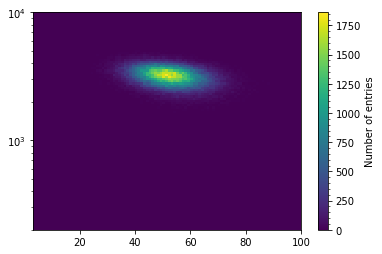

In [77]:
plt.clf()
h_er10line.plot()
plt.yscale("log")
plt.show()

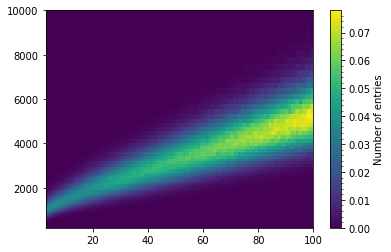

In [7]:
plt.clf()
h_er.plot()
plt.show()

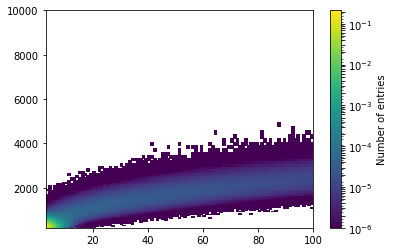

In [52]:
plt.clf()
h_nr.plot(log_scale=True,log_scale_vmin=0.000001)
plt.show()

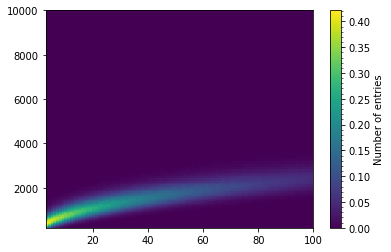

In [8]:
plt.clf()
h_50gev.plot()
plt.show()

In [12]:
def get_pdfmask(hist,fill_value = 1e-20,fraction = 0.5):
    
    hist_pdf = hist.similar_blank_hist()
    hist_pdf.histogram = hist.histogram / hist.bin_volumes()
    
    mus = hist.histogram.flatten()
    pdfs = hist_pdf.histogram.flatten()
    musigs_pdfsorted = [mu for _, mu in sorted(zip(pdfs,mus),reverse=True)]
    cmusigs_pdfsorted = np.cumsum(musigs_pdfsorted)
    i_threshold = np.argmax(fraction*cmusigs_pdfsorted[-1]<cmusigs_pdfsorted)
    threshold = sorted(pdfs,reverse=True)[i_threshold]
    mask =  hist_pdf.histogram < threshold
    
    return mask, hist_pdf, threshold



In [27]:
def get_pdfthresholds(hist,fill_value = 1e-20,fractions = [0.5]):
    
    thresholds = []
    for fraction in fractions:
        hist_pdf = hist.similar_blank_hist()
        hist_pdf.histogram = hist.histogram / hist.bin_volumes()
        
        mus = hist.histogram.flatten()
        pdfs = hist_pdf.histogram.flatten()
        musigs_pdfsorted = [mu for _, mu in sorted(zip(pdfs,mus),reverse=True)]
        cmusigs_pdfsorted = np.cumsum(musigs_pdfsorted)
    
        i_threshold = np.argmax(fraction*cmusigs_pdfsorted[-1]<cmusigs_pdfsorted)
        threshold = sorted(pdfs,reverse=True)[i_threshold]
        thresholds.append(threshold)
    
    return thresholds



In [28]:
2*sps.norm().cdf(1)-1

0.6826894921370859

In [32]:

thresholds = get_pdfthresholds(h_50gev,fractions= [2*sps.norm().cdf(s)-1 for s in [3,2,1]])

In [40]:
thresholds

[0.0006674629624382174,
 0.001198201105043131,
 0.0018748724982855399,
 0.0027628793867959275,
 0.003866004122645767,
 0.005370708269743559,
 0.007416007302681818,
 0.0106154374660774,
 0.015563805352292846]

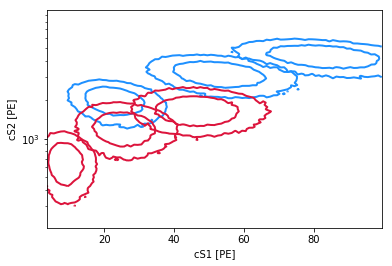

In [80]:
plt.clf()
ts = [2*sps.norm().cdf(s)-1 for s in [2,1]]
for h,color in zip([h_er5line, h_er10line, h_er15line],["dodgerblue","dodgerblue","dodgerblue"]):
    thresholds = get_pdfthresholds(h,fractions= ts)
    h_pdf = h.similar_blank_hist()
    h_pdf.histogram = h.histogram / h.bin_volumes()
    plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors=color)
for h,color in zip([h_5line, h_10line, h_15line],["crimson","crimson","crimson"]):
    thresholds = get_pdfthresholds(h,fractions= ts)
    h_pdf = h.similar_blank_hist()
    h_pdf.histogram = h.histogram / h.bin_volumes()
    plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors=color)

plt.xlabel("cS1 [PE]")
plt.ylabel("cS2 [PE]")

plt.yscale("log")
plt.savefig("monodistro_plot.png")
plt.savefig("monodistro_plot.pdf")
plt.show()

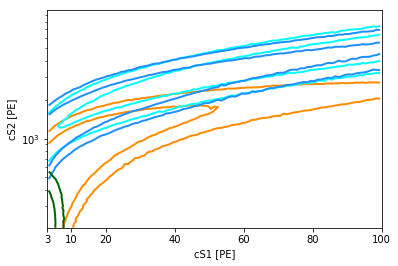

In [106]:
plt.clf()
ts = [2*sps.norm().cdf(s)-1 for s in [2,1]]
thresholds = get_pdfthresholds(h_50gev,fractions= ts)
h_pdf = h_50gev.similar_blank_hist()
h_pdf.histogram = h_50gev.histogram / h_50gev.bin_volumes()
plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors="darkorange")

thresholds = get_pdfthresholds(h_erxe,fractions= ts)
h_pdf = h_erxe.similar_blank_hist()
h_pdf.histogram = h_erxe.histogram / h_erxe.bin_volumes()
plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors="cyan")

thresholds = get_pdfthresholds(h_ernu,fractions= ts)
h_pdf = h_ernu.similar_blank_hist()
h_pdf.histogram = h_ernu.histogram / h_ernu.bin_volumes()
plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors="dodgerblue")

thresholds = get_pdfthresholds(h_nrsun,fractions= ts)
h_pdf = h_nrsun.similar_blank_hist()
h_pdf.histogram = h_nrsun.histogram / h_nrsun.bin_volumes()
plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors="darkgreen")

plt.xticks([3,10,20,40,60,80,100])
plt.xlabel("cS1 [PE]")
plt.ylabel("cS2 [PE]")

plt.yscale("log")
plt.savefig("distro_plot.png")
plt.savefig("distro_plot.pdf")
plt.show()

In [11]:
mask = get_pdfmask(h_50gev)

In [26]:
thresholds

[0.02826540294846613, 0.02826540294846613, 0.02826540294846613]

[]

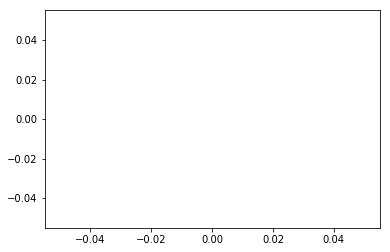

In [83]:
plt.plot()

In [84]:
def get_llrmask(hist_bkg, hist_sig,
                fill_value = 1e-20,fraction = 0.5
                ):
    
    hist_sdb = hist_sig.similar_blank_hist()
    hist_sdb.histogram = (hist_sig.histogram+fill_value) / (hist_bkg.histogram+fill_value)
    
    musigs = hist_sig.histogram.flatten()
    sdbs = hist_sdb.histogram.flatten()
    musigs_sdbsorted = [musig for _, musig in sorted(zip(sdbs,musigs),reverse=True)]
    cmusigs_sdbsorted = np.cumsum(musigs_sdbsorted)
    i_threshold = np.argmax(fraction*cmusigs_sdbsorted[-1]<cmusigs_sdbsorted)
    threshold = sorted(sdbs,reverse=True)[i_threshold]
    mask =  hist_sdb.histogram < threshold
    
    return mask



In [129]:
from copy import deepcopy

In [ ]:
np.cop

In [130]:
llrmask = get_llrmask(h_er, h_50gev,fraction=0.5)
h_mask = h_er.similar_blank_hist()
h_mask.histogram = llrmask.astype(float)
h_mask2 = h_er.similar_blank_hist()
h_mask2.histogram =  np.copy(h_er.histogram)
h_mask2[llrmask] = 0.

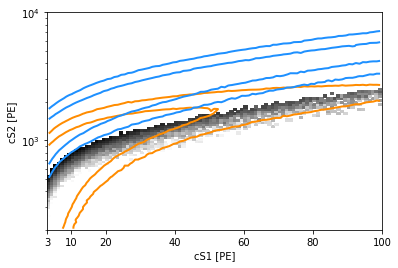

In [133]:
plt.clf()
h_mask2.plot(log_scale=True,log_scale_vmin=0.00001,colorbar=False,cmap="gray_r")
thresholds = get_pdfthresholds(h_50gev,fractions= ts)
h_pdf = h_50gev.similar_blank_hist()
h_pdf.histogram = h_50gev.histogram / h_50gev.bin_volumes()
plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors="darkorange")

thresholds = get_pdfthresholds(h_er,fractions= ts)
h_pdf = h_er.similar_blank_hist()
h_pdf.histogram = h_er.histogram / h_er.bin_volumes()
plt.contour(h_pdf.bin_centers()[0], h_pdf.bin_centers()[1],h_pdf.histogram.T,levels=thresholds,colors="dodgerblue")
plt.xticks([3,10,20,40,60,80,100])
plt.xlabel("cS1 [PE]")
plt.ylabel("cS2 [PE]")

plt.yscale("log")
plt.savefig("leakage_plot.png")
plt.savefig("leakage_plot.pdf")
plt.show()

In [45]:
hp = h_50gev.project(axis=0)
hp.histogram = (hp.n-hp.cumulative_histogram)/hp.n

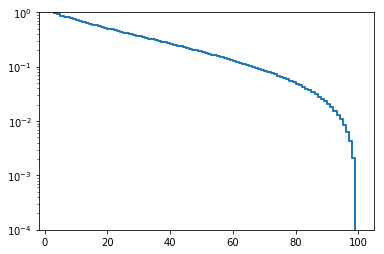

In [46]:
plt.clf()
hp.plot()
plt.yscale("log")
plt.ylim(1e-4,1)
plt.show()

In [47]:
mu_er_tot = h_er.n
mu_er_sub = h_er.n - np.sum(h_er.histogram[llrmask])

In [48]:
mu_er_sub

0.028322093643865287

In [49]:
np.sum(h_er.histogram[llrmask])/h_er.n

0.9996027970304313